In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# MNIST Dataset

In [2]:
mnist = tf.keras.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

X_train = X_train/255
X_test = X_test/255
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=10)
Y_test = tf.keras.utils.to_categorical(Y_test, num_classes=10)

11490434/11490434 [==============================] - 1s 0us/step


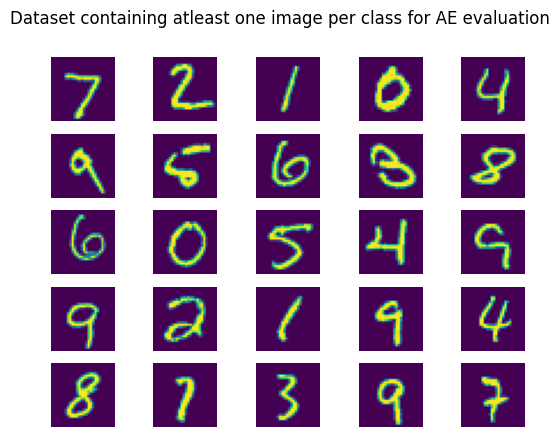

In [3]:
# Dataset containing one image from each class.
# This dataset is used to test the AutoEncoders; both Naive and Sparse
# Reconstructed images are based on this dataset

X_test_reduced = []
Y_test_reduced = []
Y_test1 = Y_test.tolist()

for i in range(len(X_test)):
    label = Y_test1[i]
    if label not in Y_test_reduced:
        X_test_reduced.append(X_test[i])
        Y_test_reduced.append(label)

for r in range(15):
    X_test_reduced.append(X_test[r+100])
plt.figure()
plt.suptitle('Dataset containing atleast one image per class for AE evaluation')
for i in range(5):
  for j in range(5):
    ax=plt.subplot2grid((5, 5), (i, j))
    ax.imshow(X_test_reduced[i*5+j])
    plt.axis('off')
X_test_reduced = np.array(X_test_reduced)
X_test_reduced = tf.convert_to_tensor(X_test_reduced.reshape((25, 28, 28)))


# Softmax MNIST Classification

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(10, activation='softmax')
])

optimizer =  tf.keras.optimizers.SGD(learning_rate=0.01)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

class SaveWeightsCallback(tf.keras.callbacks.Callback):
    def __init__(self, epochs_to_save):
        super(SaveWeightsCallback, self).__init__()
        self.epochs_to_save = epochs_to_save
        self.saved_weights = []

    def on_epoch_end(self, epoch, logs=None):
        if epoch in self.epochs_to_save:
          self.saved_weights.append(self.model.layers[1].get_weights())
          print(f"Saved weights at epoch {epoch} to a variable")


In [ ]:
save_weights = SaveWeightsCallback([19,199])
Accuracy = model.fit(X_train, Y_train, epochs=200, batch_size=32, validation_data=(X_test, Y_test), callbacks=[save_weights])

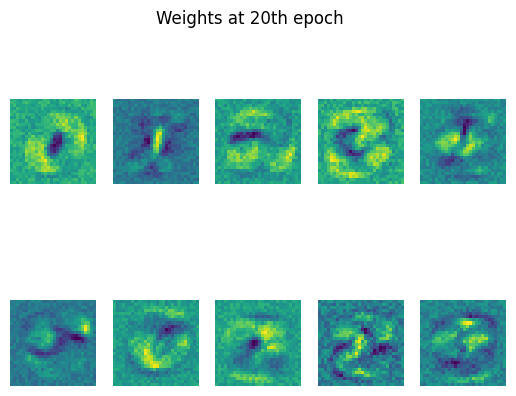

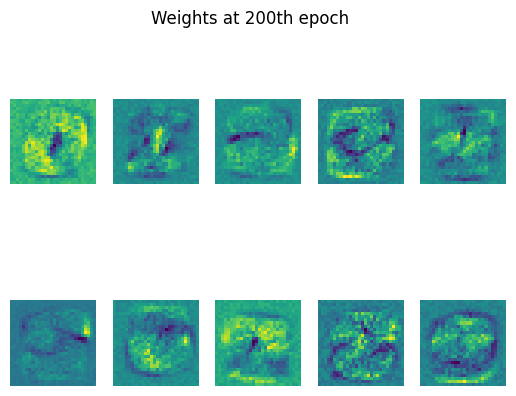

In [ ]:
w = save_weights.saved_weights
w_20 = w[0]
w_200 = w[1]

w_20 = w_20[0]
w_200 = w_200[0]

plt.figure()
plt.suptitle('Weights at 20th epoch')
for i in range(2):
  for j in range(5):
    ax=plt.subplot2grid((2, 5), (i, j))
    ax.imshow(w_20[:,i*5+j].reshape((28,28)))
    plt.axis('off')

plt.figure()
plt.suptitle('Weights at 200th epoch')
for i in range(2):
  for j in range(5):
    ax=plt.subplot2grid((2, 5), (i, j))
    ax.imshow(w_200[:,i*5+j].reshape((28,28)))
    plt.axis('off')

Text(0, 0.5, 'Test Accuracy ')

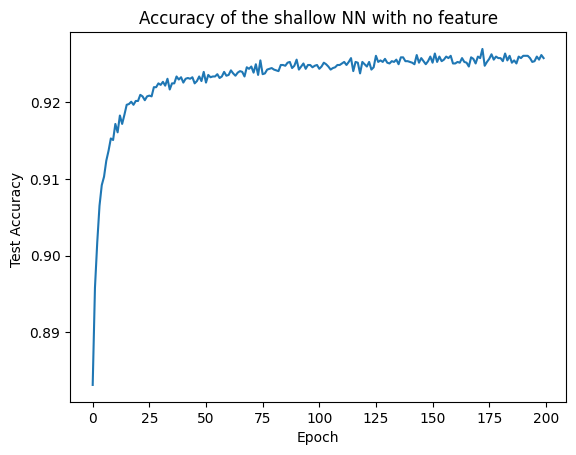

In [ ]:
accu = Accuracy.history['val_accuracy']
plt.figure()
plt.plot(accu)
plt.title('Accuracy of the shallow NN with no feature')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy ')

# Naive' Auto Encoder

In [4]:
class NaiveAutoEncoder(tf.keras.Model):
    def __init__(self):
        super(NaiveAutoEncoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(100, activation='sigmoid', input_shape=(28*28,))
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(28*28, activation='sigmoid')
        ])

    def call(self, x):
        x = tf.reshape(x, [-1, 28*28])
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

In [ ]:
N_AE = NaiveAutoEncoder()

learning_rate = 0.9
batch_size = 64
num_epochs = 600
optimizer = tf.keras.optimizers.SGD(learning_rate)
train_loss = np.zeros(num_epochs)

for epoch in range(num_epochs):
    train_running_loss = 0.0

    for i in range(0, len(X_train), batch_size):
        batch_images = X_train[i:i+batch_size]
        with tf.GradientTape() as tape:
            Xh, encoded_H = N_AE(batch_images)
            loss = tf.keras.losses.MeanSquaredError()(tf.reshape(batch_images, (len(Xh), 784)), Xh)
        gradients = tape.gradient(loss, N_AE.trainable_variables)
        optimizer.apply_gradients(zip(gradients, N_AE.trainable_variables))
        train_running_loss += loss.numpy()

    train_loss[epoch] = train_running_loss / (len(X_train) // batch_size)


Text(0, 0.5, 'Training Loss')

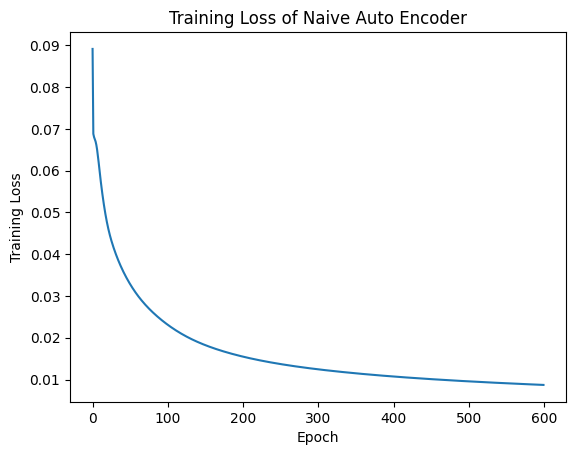

In [17]:
plt.figure()
plt.plot(train_loss)
plt.title('Training Loss of Naive Auto Encoder')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

Text(0.5, 1.0, 'Hidden Unit Activations')

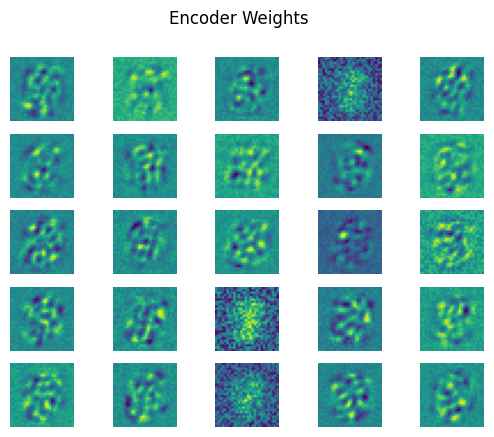

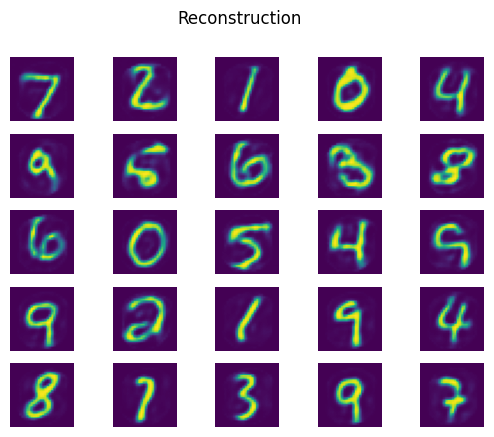

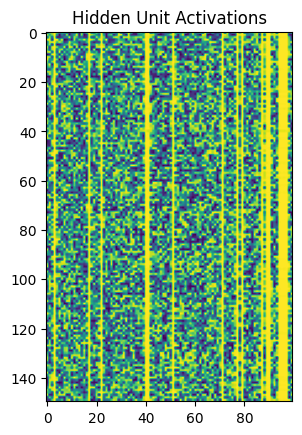

In [19]:
# Plot of Encoder weights, encoder activation and
# reconstructed images based on the reduced dataset
# containing atleast one image per class

N_We = N_AE.encoder.get_weights()[0]
N_bias = N_AE.encoder.get_weights()[1]
plt.figure()
plt.suptitle('Encoder Weights')
for i in range(5):
  for j in range(5):
    ax=plt.subplot2grid((5, 5), (i, j))
    ax.imshow(N_We[:,i*5+j].reshape((28,28)))
    plt.axis('off')

Xh, N_H = N_AE(X_test_reduced)
Xh = tf.reshape(Xh, (25,28,28))
plt.figure()
plt.suptitle('Reconstruction')
for i in range(5):
  for j in range(5):
    ax=plt.subplot2grid((5, 5), (i, j))
    ax.imshow(Xh[i*5+j,:,:])
    plt.axis('off')

Xh_1, N_H = N_AE(X_test)
N_H = N_H[0:150,:]

plt.figure()
ax=plt.subplot2grid((1, 1), (0, 0))
ax.imshow(N_H)
plt.title('Hidden Unit Activations')

In [ ]:
# Training shallow NN with the feature learned from the Naive AE

N_We = N_AE.encoder.get_weights()[0]
N_bias = N_AE.encoder.get_weights()[1]
model_N_AE = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='sigmoid', trainable=False),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_N_AE.layers[1].set_weights([N_We, N_bias])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.4)
model_N_AE.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

N_AE_Accuracy = model_N_AE.fit(X_train, Y_train, epochs=200, batch_size=10, validation_data=(X_test, Y_test))


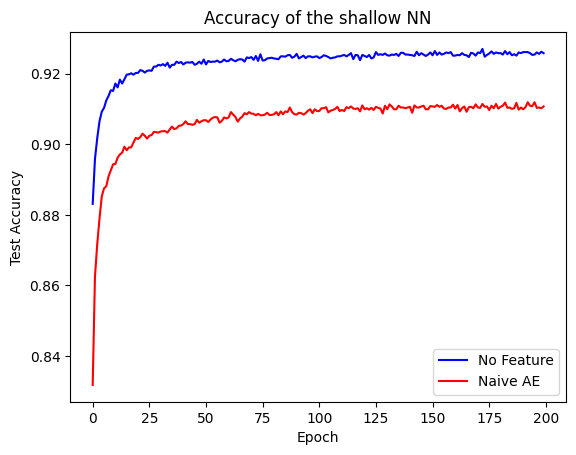

In [ ]:
# Accuracy plot comparing Accuracy of shallow NN with no features and
# Shallow NN with features learned from the Naive AutoEncoder

N_AE_accu = N_AE_Accuracy.history['val_accuracy']
plt.figure()
plt.plot(accu, label='No Feature', color='blue')
plt.plot(N_AE_accu, label='Naive AE', color='red')
plt.title('Accuracy of the shallow NN')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()

# Sparse Auto Encoder

In [20]:
class SparseAutoEncoder(tf.keras.Model):
    def __init__(self):
        super(SparseAutoEncoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(100, activation='sigmoid', input_shape=(28*28,))
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(28*28, activation='sigmoid')
        ])

    def call(self, x):
        x = tf.reshape(x, [-1, 28*28])
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

In [21]:
class CustomLoss(tf.keras.losses.Loss):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def call(self, targets, y_pred):
        alpha = 0.2 #0.5
        lmbda = 0.01 #0.01
        inputs, H = y_pred
        alpha_h = tf.reduce_mean(H, axis=1, keepdims=True)
        KL = (alpha * tf.math.log(alpha / alpha_h)) + ((1 - alpha) * tf.math.log((1 - alpha) / (1 - alpha_h)))
        mse_loss = tf.keras.losses.MeanSquaredError()(targets, inputs)
        kl_loss = tf.reduce_sum(KL)
        return mse_loss + lmbda * kl_loss


In [ ]:
# Training Sparse Auto Encoder using custom Loss
S_AE = SparseAutoEncoder()

learning_rate = 0.9
batch_size = 64
num_epochs = 200
optimizer = tf.keras.optimizers.SGD(learning_rate)
train_loss = np.zeros(num_epochs)

for epoch in range(num_epochs):
    train_running_loss = 0.0

    for i in range(0, len(X_train), batch_size):
        batch_images = X_train[i:i+batch_size]
        with tf.GradientTape() as tape:
            Xh, encoded_H = S_AE(batch_images)
            loss = CustomLoss()(tf.reshape(batch_images, (len(Xh), 784)), (Xh, tf.transpose(encoded_H)))
        gradients = tape.gradient(loss, S_AE.trainable_variables)
        optimizer.apply_gradients(zip(gradients, S_AE.trainable_variables))
        train_running_loss += loss.numpy()

    train_loss[epoch] = train_running_loss / (len(X_train) // batch_size)

Text(0, 0.5, 'Training Loss')

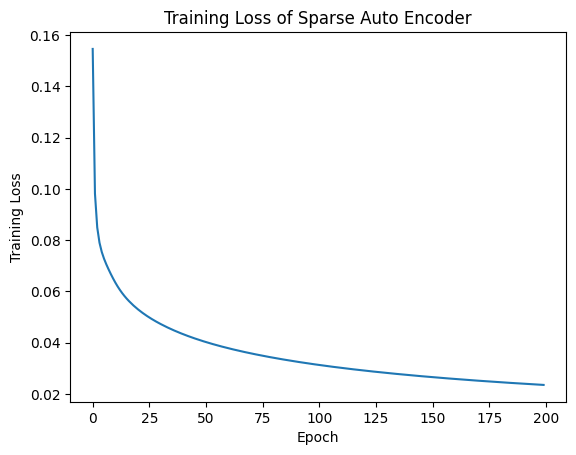

In [23]:
plt.figure()
plt.plot(train_loss)
plt.title('Training Loss of Sparse Auto Encoder')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

Text(0.5, 1.0, 'Hidden Unit Activations')

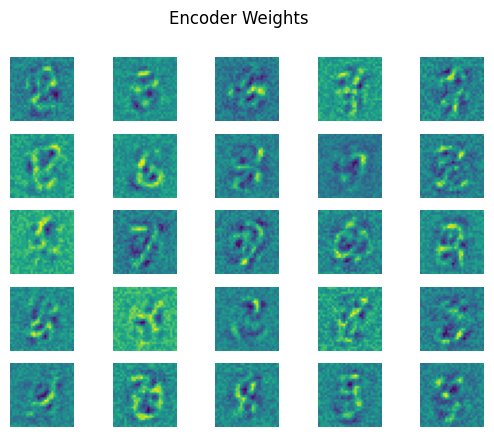

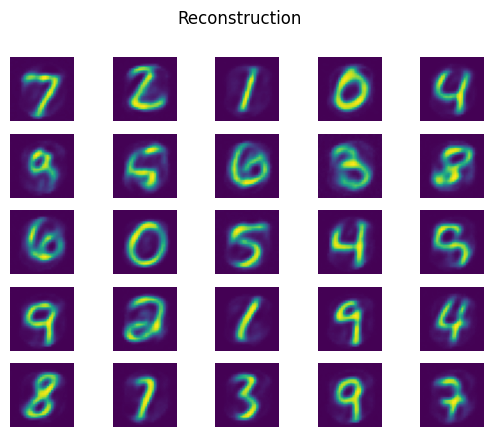

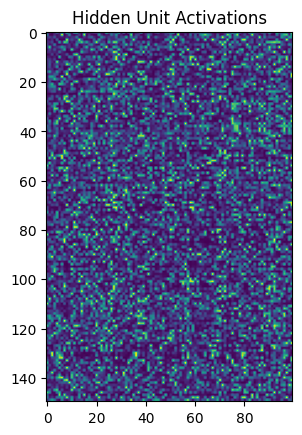

In [ ]:
# Plot of Encoder weights, encoder activation and
# reconstructed images based on the reduced dataset
# containing atleast one image per class

S_We = S_AE.encoder.get_weights()[0]
S_bias = S_AE.encoder.get_weights()[1]
plt.figure()
plt.suptitle('Encoder Weights')
for i in range(5):
  for j in range(5):
    ax=plt.subplot2grid((5, 5), (i, j))
    ax.imshow(S_We[:,i*5+j].reshape((28,28)))
    plt.axis('off')

Xh, S_H = S_AE(X_test_reduced)
Xh = tf.reshape(Xh, (25,28,28))
plt.figure()
plt.suptitle('Reconstruction')
for i in range(5):
  for j in range(5):
    ax=plt.subplot2grid((5, 5), (i, j))
    ax.imshow(Xh[i*5+j,:,:])
    plt.axis('off')

Xh_1, S_H = S_AE(X_test)
S_H = S_H[0:150,:]

plt.figure()
ax=plt.subplot2grid((1, 1), (0, 0))
ax.imshow(S_H)
plt.title('Hidden Unit Activations')

In [ ]:
# Training shallow NN with the feature learned from the Sparsed AE
S_We = S_AE.encoder.get_weights()[0]
S_bias = S_AE.encoder.get_weights()[1]
model_S_AE = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='sigmoid', trainable=False),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_S_AE.layers[1].set_weights([S_We, S_bias])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.4)
model_S_AE.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

S_AE_Accuracy = model_S_AE.fit(X_train, Y_train, epochs=200, batch_size=10, validation_data=(X_test, Y_test))

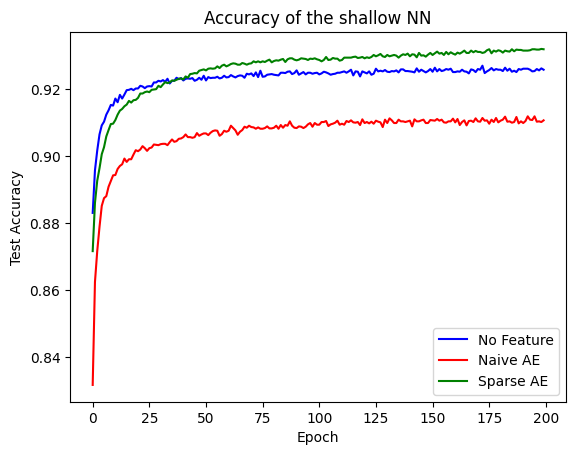

In [ ]:
# Accuracy plot comparing Accuracy of shallow NN with no features and
# Shallow NN with features learned from the Naive AutoEncoder and Sparse AutoEncoder

N_AE_accu = N_AE_Accuracy.history['val_accuracy']
S_AE_accu = S_AE_Accuracy.history['val_accuracy']
plt.figure()
plt.plot(accu, label='No Feature', color='blue')
plt.plot(N_AE_accu, label='Naive AE', color='red')
plt.plot(S_AE_accu, label='Sparse AE', color='green')
plt.title('Accuracy of the shallow NN')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()

# **Comments**

1. Reconstructed images from the Sparse AutoEncoder tend to exhibit a slight blurriness when compared to those generated by the Naive AutoEncoder. This phenomenon arises from the Sparse AutoEncoder's inclination to emphasize only the most essential features during its learning process. This emphasis is a direct consequence of the sparsity constraint incorporated into the Sparse AutoEncoder, which encourages the network to represent data in a more condensed manner, occasionally at the expense of finer details to optimize efficiency.

2. In the Sparse AutoEncoder, the activations of hidden units tend to exhibit higher sparsity when contrasted with the Naive AutoEncoder. This means that not all neurons within the Sparse AutoEncoder's hidden layer are active at all times.

3. The shallow network utilizing features acquired from Sparse AutoEncoders demonstrates superior performance compared to its counterpart that relies on features obtained from Naive AutoEncoders. This advantage stems from the fact that Sparse AutoEncoders focus on learning essential features while disregarding minor details. This selective feature learning enables the network to excel in classification tasks, even though the sparse encoder initially had no knowledge of the specific classification objectives during its activation value learning phase.

# A shallow NN for MNIST classification


In [ ]:
model_NN = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax')
])

optimizer =  tf.keras.optimizers.SGD(learning_rate=0.05)

model_NN.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

NN_Accuracy = model_NN.fit(X_train, Y_train, epochs=200, batch_size=32, validation_data=(X_test, Y_test))

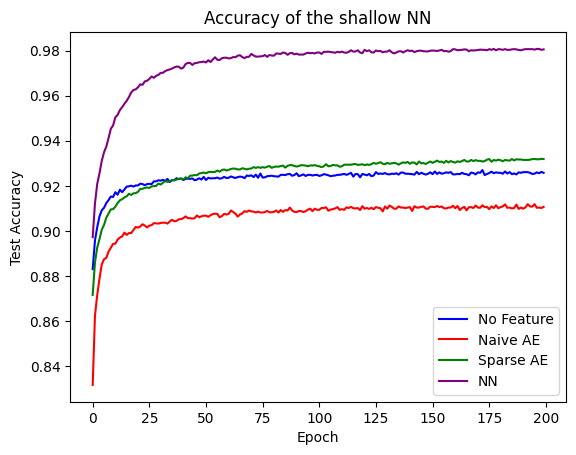

In [ ]:
# Accuracy plot comparing Accuracy of shallow NN with no features and
# Shallow NN with features learned from the Naive AutoEncoder, Sparse AE
# and the NN with self feature learning using the Backpropagation

NN_accu = NN_Accuracy.history['val_accuracy']

plt.figure()
plt.plot(accu, label='No Feature', color='blue')
plt.plot(N_AE_accu, label='Naive AE', color='red')
plt.plot(S_AE_accu, label='Sparse AE', color='green')
plt.plot(NN_accu, label='NN', color='purple')
plt.title('Accuracy of the shallow NN')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()


# **Comments**

In this task, we employed the backpropagation algorithm to train a shallow Neural Network, allowing weight updates in both layers. This approach integrates feature learning directly within the network, eliminating the need for separate AutoEncoders. Remarkably, this network surpasses all other configurations in terms of performance.

The superiority of this approach can be attributed to the fact that the shallow Neural Network acquires features with an awareness of the specific classification task it is intended for. Consequently, the feature learning process becomes highly task-oriented. In contrast, AutoEncoders learn features without knowledge of the exact classification task, instead prioritizing features necessary for optimal data reconstruction.

# Comparison of MNIST classification accuracy of a model with Sparse AE and Naive AE initializations 

In [ ]:
## Back propagation with Naive AE weight initialization
model_NN_N_AE = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax')
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.04)
model_NN_N_AE.layers[1].set_weights([N_We, bias])
model_NN_N_AE.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

NN_N_AE_Accuracy = model_NN_N_AE.fit(X_train, Y_train, epochs=200, batch_size=32, validation_data=(X_test, Y_test))

In [ ]:
## Back propagation with Sparse AE weight initialization
model_NN_S_AE = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model_NN_S_AE.layers[1].set_weights([S_We, S_bias])
optimizer =  tf.keras.optimizers.SGD(learning_rate=0.04)
model_NN_S_AE.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

NN_S_AE_Accuracy = model_NN_S_AE.fit(X_train, Y_train, epochs=200, batch_size=32, validation_data=(X_test, Y_test))

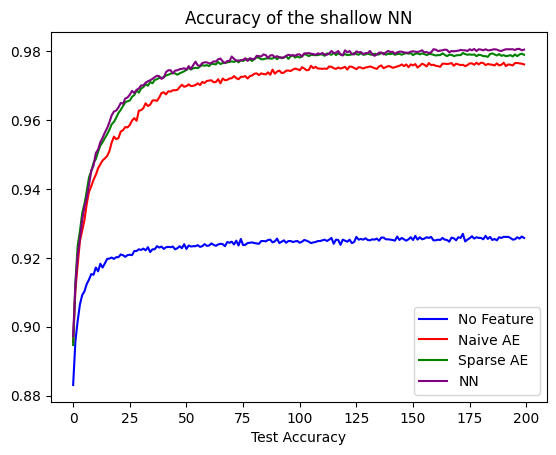

In [ ]:
NN_N_AE_accu = NN_N_AE_Accuracy.history['val_accuracy']
NN_S_AE_accu = NN_S_AE_Accuracy.history['val_accuracy']

plt.figure()
plt.plot(accu, label='No Feature', color='blue')
plt.plot(NN_N_AE_accu, label='Naive AE', color='red')
plt.plot(NN_S_AE_accu, label='Sparse AE', color='green')
plt.plot(NN_accu, label='NN', color='purple')
plt.title('Accuracy of the shallow NN')
plt.xlabel('Epoch')
plt.xlabel('Test Accuracy')
plt.legend()


# **Comments**

When training a shallow neural network and updating the weights through backpropagation, it appears that feature learning may not yield significant benefits. Ultimately, all of our shallow networks seem to converge to the same level of accuracy, whether we perform feature learning using Sparse or Naive Auto Encoders or not. Consequently, in the context of a shallow neural network, feature learning appears to be an inconsequential addition, adding unnecessary computational cost without substantial performance improvement.

# # Comparison of MNIST classification accuracy of a model with different inbuilt initializations 

In [ ]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='sigmoid', kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.01)),
    tf.keras.layers.Dense(512, activation='sigmoid',  kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.01)),
    tf.keras.layers.Dense(512, activation='sigmoid', kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.01)),
    tf.keras.layers.Dense(512, activation='sigmoid', kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.01)),
    tf.keras.layers.Dense(512, activation='sigmoid', kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.01)),
    tf.keras.layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.04)
model_1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
Accuracy_1 = model_1.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test))

In [ ]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='sigmoid', kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dense(512, activation='sigmoid',  kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dense(512, activation='sigmoid',  kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dense(512, activation='sigmoid',  kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dense(512, activation='sigmoid',  kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
model_2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
Accuracy_2 = model_2.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test))

In [ ]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.01)),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.01)),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.01)),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.01)),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.01)),
    tf.keras.layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
model_3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
Accuracy_3 = model_3.fit(X_train, Y_train, epochs=50, batch_size=90, validation_data=(X_test, Y_test))

In [ ]:
model_4 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model_4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
Accuracy_4 = model_4.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test))

In [ ]:
model_5 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model_5.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
Accuracy_5 = model_5.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test))

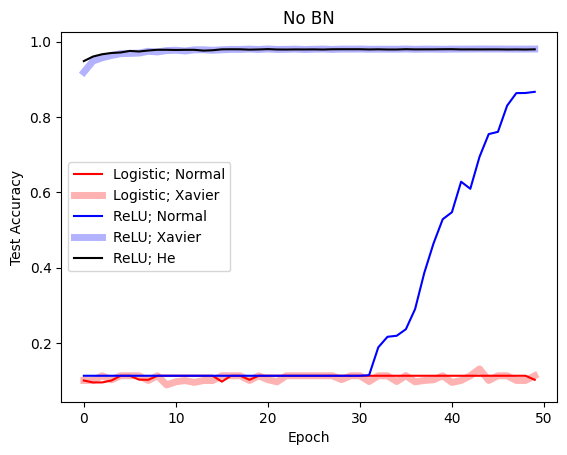

In [ ]:
accu1 = Accuracy_1.history['val_accuracy']
accu2 = Accuracy_2.history['val_accuracy']
accu3 = Accuracy_3.history['val_accuracy']
accu4 = Accuracy_4.history['val_accuracy']
accu5 = Accuracy_5.history['val_accuracy']

plt.figure()

plt.plot(accu1, label='Logistic; Normal', color='red')
plt.plot(accu2, label='Logistic; Xavier', color='red', linewidth=5, alpha=0.3)
plt.plot(accu3, label='ReLU; Normal', color='blue')
plt.plot(accu4, label='ReLU; Xavier', color='blue', linewidth=5, alpha=0.3)
plt.plot(accu5, label='ReLU; He ', color='black')

plt.title('No BN')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()

# **Comments**

The performance of shallow Neural Networks is notably influenced by two critical factors: weight initialization and activation functions. Furthermore, the interplay between these elements proves to be pivotal. For instance, Xavier initialization may not yield optimal results when paired with the logistic function, but it exhibits better performance when coupled with the ReLU activation function. In our specific case, the Kamming He initialization method stands out as the optimal choice when used in conjunction with the ReLU activation function, delivering the best results.